# Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns

In this notebook we present a concrete example of estimating the media effects via bayesian methods, following the strategy outlined in Google's paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/). This example can be considered the continuation of the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/). However, it is not strictly necessary to read before as we make this notebook self-contained. 

## Data Generation Process

In [Part I](https://juanitorduz.github.io/orbit_mmm/) of the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/), we generated a synthetic dataset where we modeled a target variable `y` (sales) as a function of a trend, a seasonal component and an external regressor `z` (media spend). The effect of `z` on `y` was specified by the composition two transformations: a carryover effect (adstock) and a shape (saturation) effect.These two transformations have proven successful in practical Media Mix Modeling.

- The (geometric) [adstock transformation](https://en.wikipedia.org/wiki/Advertising_adstock) is parametrized by the decaying parameter $\alpha$ and the carryover parameter $\ell$. For this specific dataset, we set $\alpha = 0.5$ and $\ell =12$.
- The saturation effect is parametrized by the shape parameter $\lambda$. In this example we set $\lambda=0.15$.

In the previous post (where we used the greek letter $\mu$ for the shape parameter), we transformed the variable `z` as:

$$
z \xrightarrow{\text{adstock}(\alpha)} z_{\text{adstock}} \xrightarrow{\text{saturation}(\lambda)} z_{\text{effect}}
$$

and generated `y` as:

$$
y(t) = \beta_{0} + \beta_{\text{trend}}\:\text{trend} + \beta_{\text{seasonality}}\:\text{seasonality} + \beta_{z}(t)\:z_{\text{effect}} + \varepsilon
$$

where the beta coefficient $\beta_{z}(t)$ was a (smooth) decaying function encoding the diminishing returns over time.

## Prophet and KTR Models

In the previous post the [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/) we fitted two models:

- **Prophet:** Given the strong seasonal patter nof the time series, we used a [Prophet](https://facebook.github.io/prophet/) model as a baseline. This model was able to successfully capture the trend ans seasonal components. On the other hand, the estimated regression coefficients $\widehat{\beta}_{z}(t)=\widehat{\beta}_{\text{Prophet}}$ was a constant (i.e. constant over time, as expected) very close to the median of $z_{\text{effect}}$.

- **KTR (Kernel-based Time-varying Regression):** The second model we used was [Orbit](https://github.com/uber/orbit)'s [KTR](https://orbit-ml.readthedocs.io/en/latest/tutorials/ktr1.html) model, on which regression coefficients are allowed to vary over time by using [*kernel smooths*](https://en.wikipedia.org/wiki/Kernel_smoother) (see [Edwin, Ng, et al. "Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling"](https://arxiv.org/abs/2106.03322) for more details). For this example, the model has able to give a good approximation $\widehat{\beta}_{z}(t)=\widehat{\beta}_{\text{KTR}}$ to the true $\beta_{z}(t)$ coefficient.

It is important to emphasize that both models where fitted using `z_adstock` as the external regressor. That is, we assumed the value of alpha was given as it is not straight forward to estimate it using the models above.

## PyMC Model

Motivated by the results above, we now want to build a bayesian model to estimate $\alpha$, $\lambda$ and $\beta_z(t)$ simultaneously (as well as the other regression coefficients for the trend and seasonality). We will use the [PyMC3](https://github.com/pymc-devs/pymc) motivated by the following great resources:

1. Simulated Example by [Dr. Robert Kübler](https://dr-robert-kuebler.medium.com/):
  - [An Upgraded Marketing Mix Modeling in Python](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)
  - [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a)
  - [Rockin‘ Rolling Regression in Python via PyMC3](https://towardsdatascience.com/rockin-rolling-regression-in-python-via-pymc3-e4722b6118cd)

2. HelloFresh's Media Mix Model: [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a). Here are some additional references for this use cases:
   
  - Article: [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6) 
  - Video: [A Bayesian Approach to Media Mix Modeling by Michael Johns & Zhenyu Wang](https://www.youtube.com/watch?v=UznM_-_760Y)
  - Articles by  [PyMC Labs](https://www.pymc-labs.io/): 
    - [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
    - [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)

Of course, the main motivation is Google's paper [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects" (2017)](https://research.google/pubs/pub46001/). Moreover, for a discussion of MMM in practice please see [Chan, David, et al. "Challenges and Opportunities in Media Mix Modeling" (2017)](https://research.google/pubs/pub45998/)

As usual in applied data analysis, we will start from simple models and iterate to add more complexity. Moreover, we will follow the recommended [bayesian workflow](https://arxiv.org/abs/2011.01808).

---

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import pearsonr
import seaborn as sns
import theano.tensor as tt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

## Read Data

We start by reading the data. This `csv` was generated in the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/), please refer to it for details. Here we give a quick overview of the data.

In [2]:
data_df = pd.read_csv("../Data/ktr_data.csv", parse_dates=["date"])

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 179 non-null    int64         
 1   date                  179 non-null    datetime64[ns]
 2   year                  179 non-null    int64         
 3   month                 179 non-null    int64         
 4   dayofyear             179 non-null    int64         
 5   z                     179 non-null    float64       
 6   z_adstock             179 non-null    float64       
 7   z_adstock_saturated   179 non-null    float64       
 8   beta                  179 non-null    float64       
 9   z_effect              179 non-null    float64       
 10  effect_ratio          179 non-null    float64       
 11  effect_ratio_smooth   179 non-null    float64       
 12  trend                 179 non-null    float64       
 13  cs                  

Let us now plot the most relevant variables for the analysis:

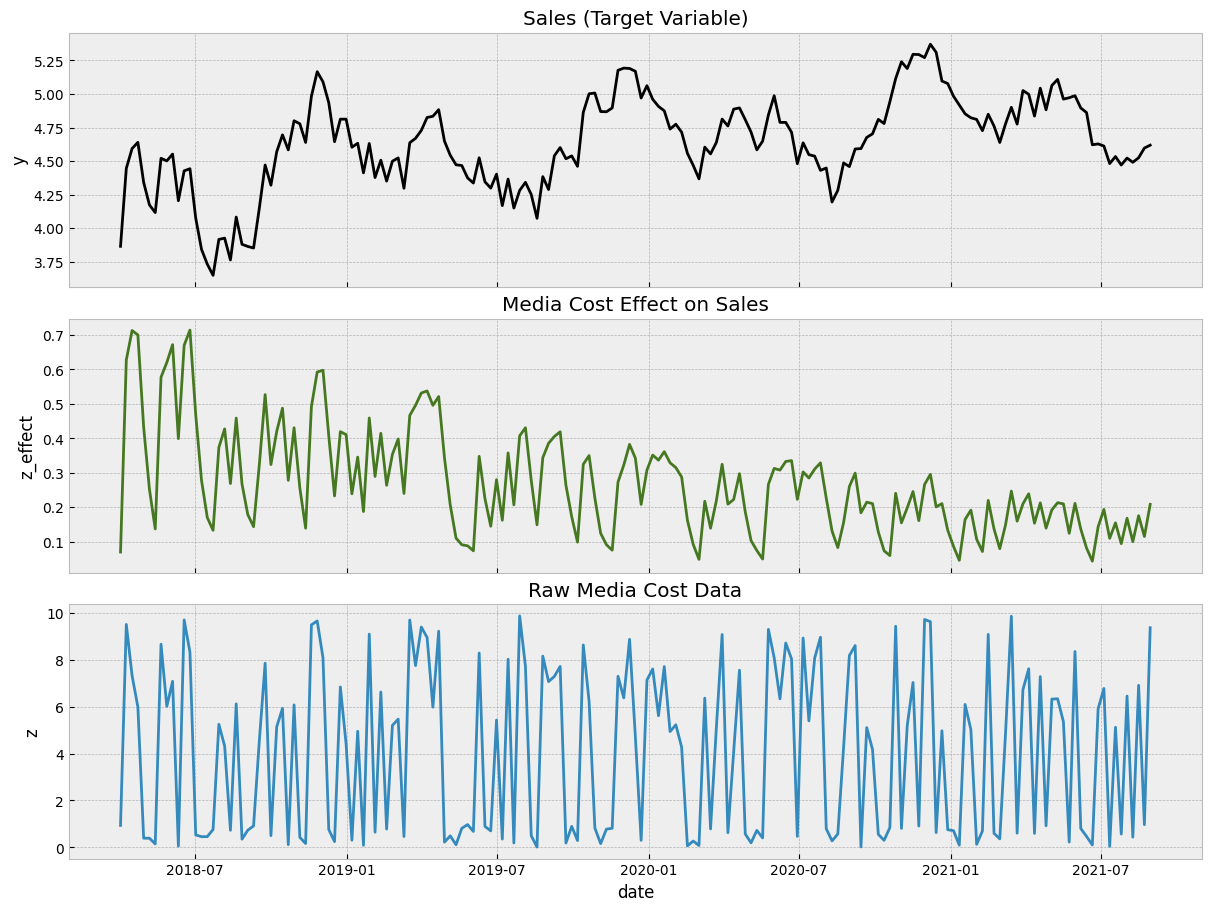

In [3]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

1. The first plot is our target variable `y`, which can represent sales data, for example.
2. the second plot is the `z_effect` variable, which is the simulated effect of the media spent variable `z` on the variable `y`. **In practice we do not know `z_effect`. We would like to infer it from the data!**
3. The last plot represent the input data `z` which is something we have control of.

Note that the variable `y` has a trend and strong (additive) yearly seasonality components.

## Features

We of course do not want to use the trend os seasonal components from  the `data_df` dataframe, as the whole point id to learn them tom the data. Hence, let us keep the variables we would actually have in when developing the model.

In [4]:
columns_to_keep = ["index", "date", "year", "month", "dayofyear", "z", "y"]

df = data_df[columns_to_keep].copy()

Next, we generate input features to model the trend and seasonal components. We follow the strategy presented in the very compprehensive post [Air passengers - Prophet-like model](https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html) from the [`pymc-examples`](https://docs.pymc.io/en/stable/pymc-examples/README.html) repository (please check it out!).

### Trend

For the trend component we simply use a linear feature (which we scale  between $0$ and $1$).

In [5]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())

### Seasonality

To model the seasonality, we use [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series) (similarly as in Prophet or Orbit).

In [6]:
n_order = 10
periods = df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

We can see how these cyclic features look like:

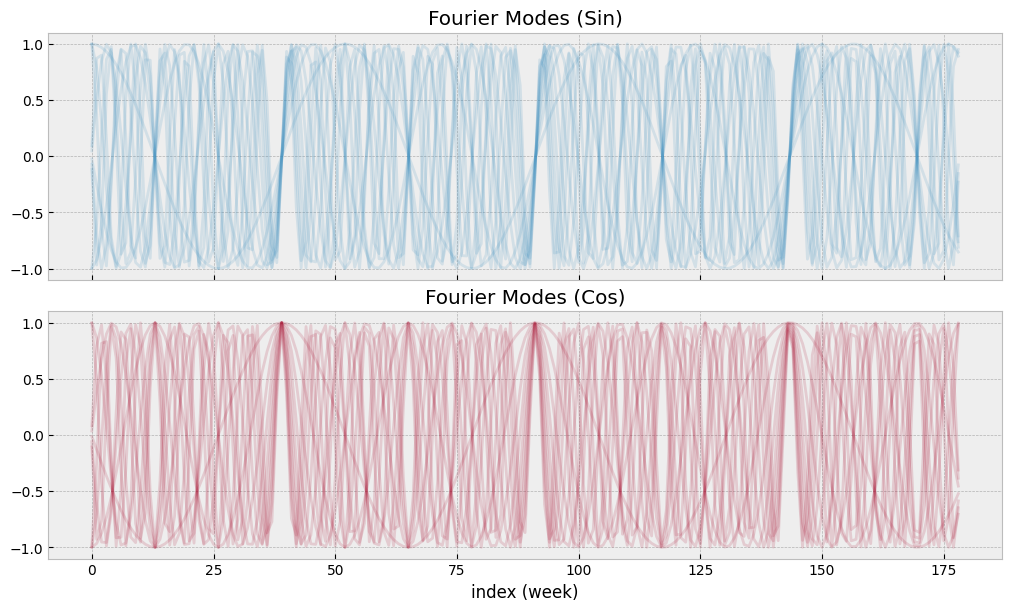

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, layout="constrained")
fourier_features.filter(like="sin").plot(color="C0", alpha=0.15, ax=ax[0])
ax[0].get_legend().remove()
ax[0].set(title="Fourier Modes (Sin)", xlabel="index (week)")
fourier_features.filter(like="cos").plot(color="C1", alpha=0.15, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set(title="Fourier Modes (Cos)", xlabel="index (week)");

Finally, we extract the target and features asn `numpy` arrays.

In [8]:
date = df["date"].values
date_index = df.index
y = df["y"].values
z = df["z"].values
t = t.values

## Models

In this section we fit $3$ models, from simpler to complex:
1. **Base Model:** We fit a linear regression model with a single regressor `z` and controlling from trend ans seasonality.

2. **Adstock-Saturation Model:** We use the same model structure as the base model but we now apply the (geometric) adstock and saturation transformations to the `z` variable. We **do not** se a variable for $\alpha$ and $\lambda$ as we learn them from the data. We do fix the variable $\ell=12$ of the adstock transformation.

3. **Adstock-Saturation-Diminishing Returns Model:** We use the same model structure as the Adstock-Saturation model but we allow a time-varying coefficient for (the transformed) `z` by modeling it as a gaussian random walk.

### Base Model

Let us start by defining the structure of the base model, which is the be the core of the models to come.

- Model Specification

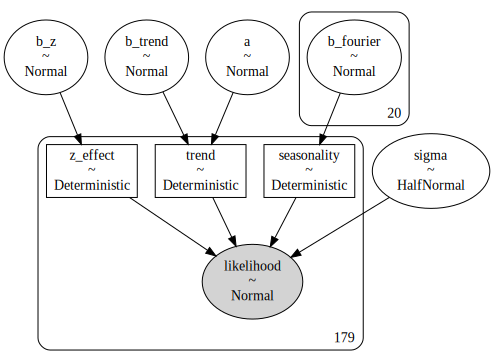

In [9]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as base_model:
    # --- priors ---
    ## intercept
    a = pm.Normal("a", mu=0, sigma=0.5)
    ## trend
    b_trend = pm.Normal("b_trend", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal("b_fourier", mu=0, sigma=0.5, dims="fourier_features")
    ## regressor
    b_z = pm.Normal("b_z", mu=0, sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    
    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T)
    )
    z_effect = pm.Deterministic("z_effect", b_z * z)
    mu = trend  + seasonality  + z_effect
    
    # --- likelihood ---
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
    
    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(base_model)

In order to generate samples form the models the following function comes very handy (taken from  [Air passengers - Prophet-like model](https://docs.pymc.io/en/stable/pymc-examples/examples/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html)):

In [10]:
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

- Prior Predictive Samples

Let us start by sampling from the model before looking into the data:

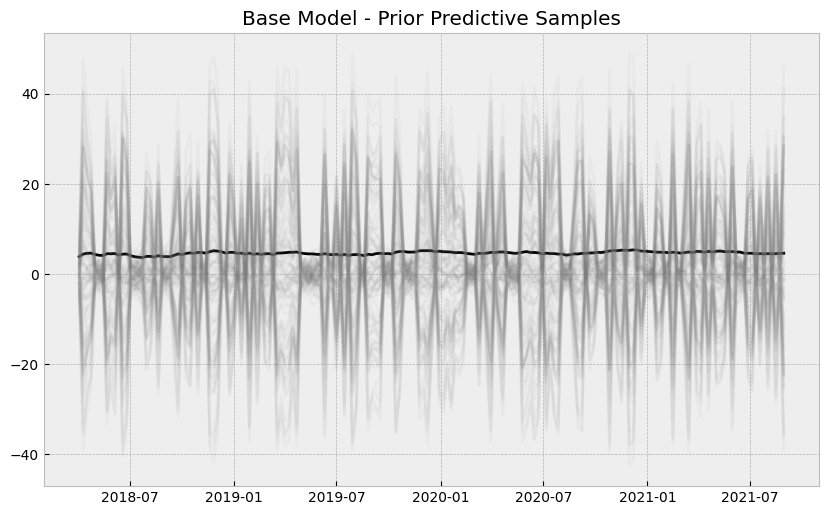

In [11]:
fig, ax = plt.subplots()
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.plot(
    date,
    _sample(array=base_model_prior_predictive["likelihood"], n_samples=100).T,
    color="gray",
    alpha=0.05,
)
ax.set(title="Base Model - Prior Predictive Samples");

The priors do constrain the range of the generated time series. Nevertheless, they are not too restrictive.

- Fit Model

In [12]:
with base_model:
    base_model_trace = pm.sample(
        tune=2000,
        draws=6000,
        chains=4,
        return_inferencedata=True
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace,
        samples=200
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_z, b_fourier, b_trend, a]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 37 seconds.
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


- Model Diagnostics

In [13]:
az.summary(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        4.214  0.016   4.183    4.244        0.0      0.0   14466.0   
b_trend  0.655  0.024   0.610    0.700        0.0      0.0   18474.0   
b_z      0.028  0.002   0.024    0.032        0.0      0.0   19562.0   
sigma    0.092  0.005   0.082    0.102        0.0      0.0   25402.0   

         ess_tail  r_hat  
a         16198.0    1.0  
b_trend   17470.0    1.0  
b_z       17530.0    1.0  
sigma     15650.0    1.0

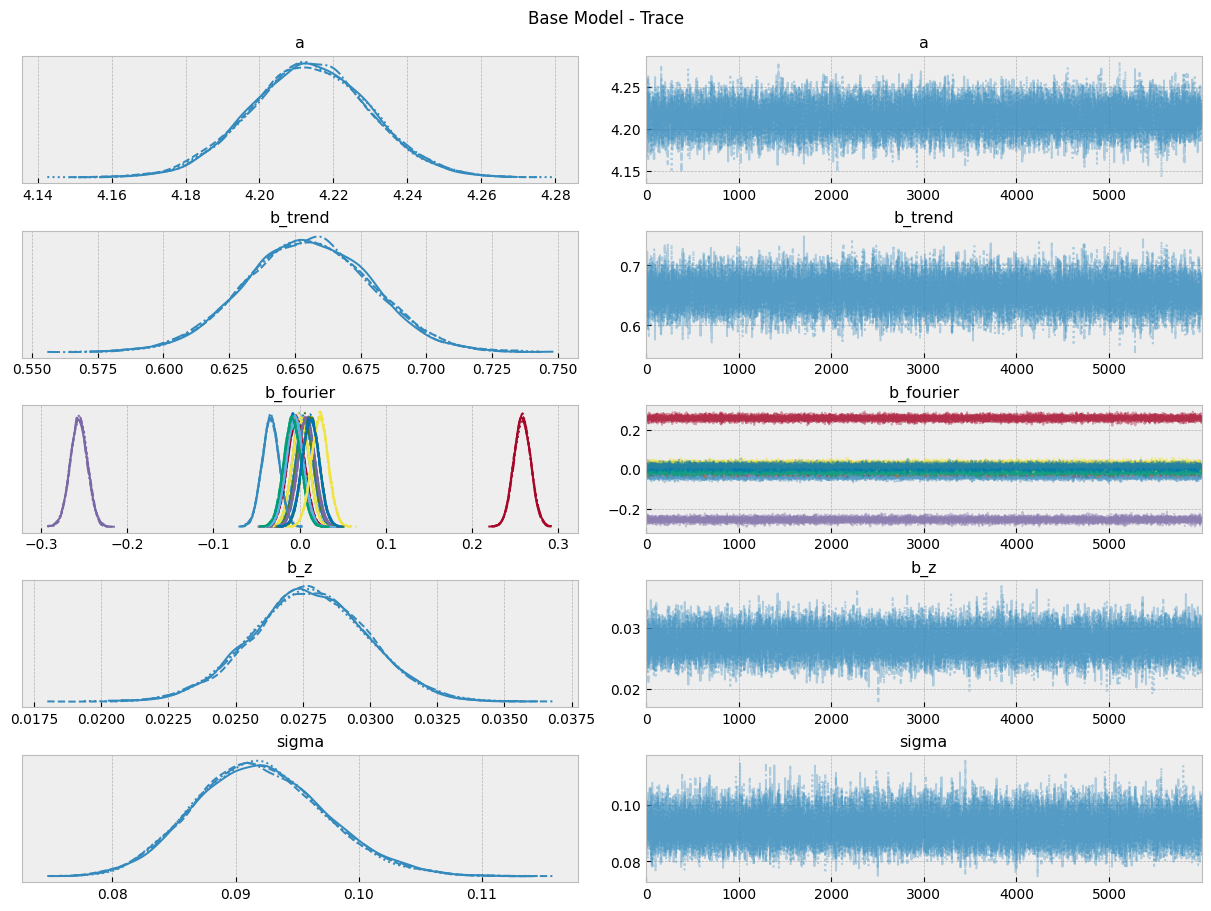

In [14]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_z", "sigma"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");

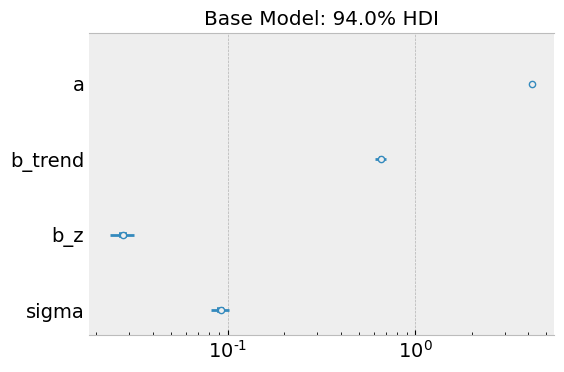

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=base_model_trace,
    var_names=["a", "b_trend", "b_z", "sigma"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
    xscale="log"
);

Overall, the model looks ok!

- Posterior Predictive Samples

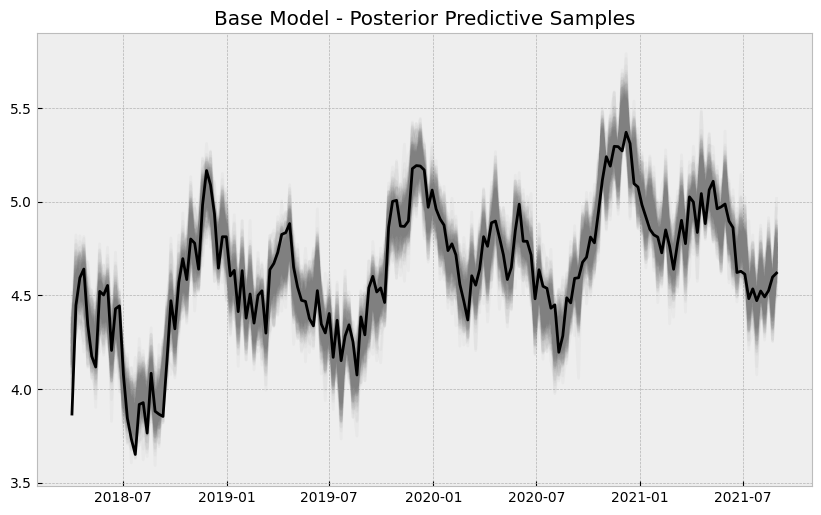

In [16]:
fig, ax = plt.subplots()
ax.plot(
    date,
    base_model_posterior_predictive["likelihood"].T,
    color="gray",
    alpha=0.05,
)
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.set(title="Base Model - Posterior Predictive Samples");

The base model does capture the trend and seasonality of the data.

- Estimated `z_effect`

Finally, let us look at the estimated effect of `z` on `y`. To begin, we include the time component:

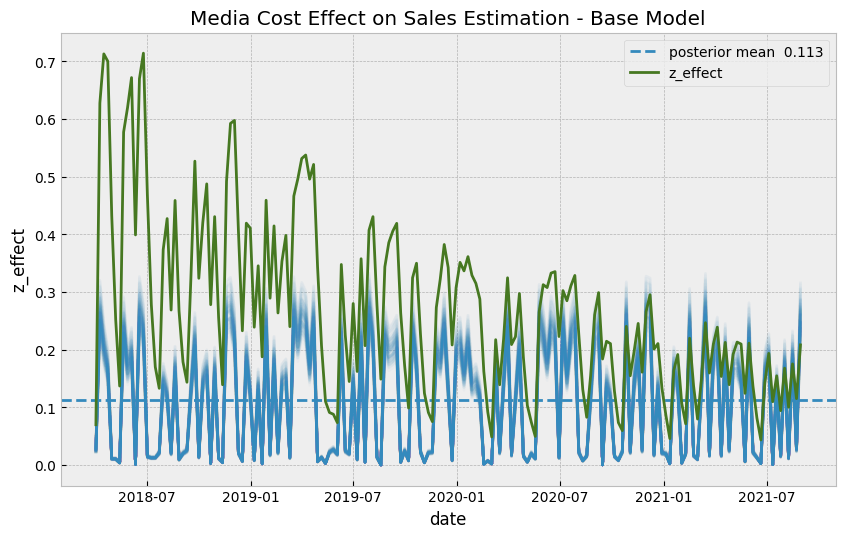

In [17]:
z_effect_posterior_samples = (
    base_model_trace["posterior"]["z_effect"].stack(sample=("chain", "draw"))
)

fig, ax = plt.subplots()
ax.plot(
    date,
    _sample(array=z_effect_posterior_samples.T, n_samples=100).T,
    color="C0",
    alpha=0.03,
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}"
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.set(title="Media Cost Effect on Sales Estimation - Base Model");

We clearly see that the effect of `z` is a linear function of `z` and does not depend on the time, as expected from the model specification.It is interesting to see that the variance of the estimated effect is similar to the real effect of the latest observations.

Next, we simply plot the estimated against the true values.

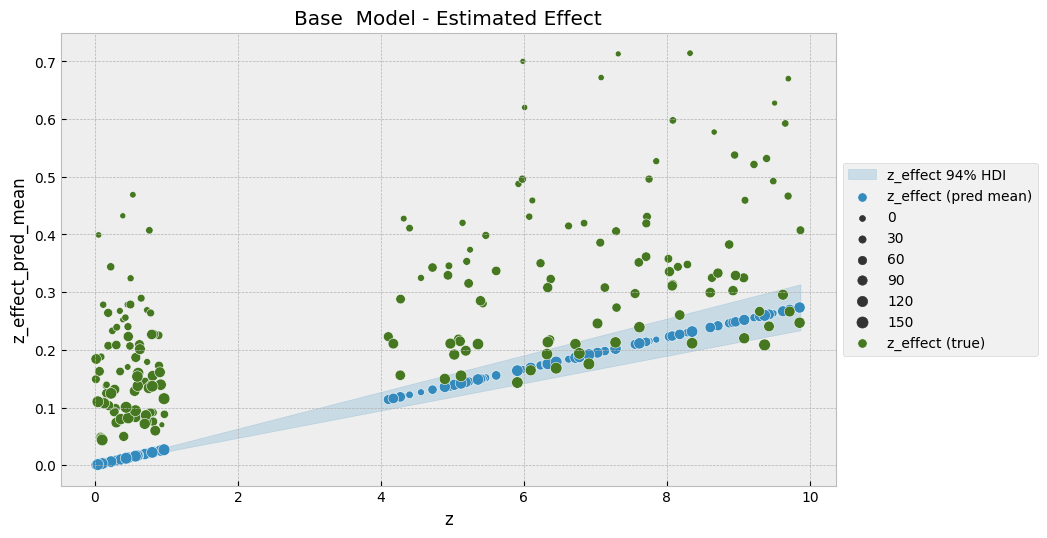

In [18]:
z_effect_pred_mean = base_model_trace["posterior"]["z_effect"] \
    .stack(sample=("chain", "draw")) \
    .mean(axis=1) \
    .to_numpy()

fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=base_model_trace["posterior"]["z_effect"],
    color="C0",
    fill_kwargs={
        "alpha": 0.2,
        "label": "z_effect 94% HDI"
    },
    ax=ax
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    label="z_effect (pred mean)",
    data=(
        data_df
        .assign(z_effect_pred_mean=z_effect_pred_mean)
    )
)
sns.scatterplot(
    x="z",
    y="z_effect",
    color="C3",
    size="index",
    label="z_effect (true)",
    data=data_df
)
h,l = ax.get_legend_handles_labels()
ax.legend(h[0:9], l[0:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Base  Model - Estimated Effect");

To encode the time component we map the size of the points to the `index`, which is a global time-component (number of weeks since the first observation). Note that the fitted values do not seem to match the data. This model is too simple to capture the non-linear interactions.

### Adstock-Saturation Model

- Features

For the second model we need to express the (geometric) adstock and saturations transformations as tensor operations:

In [19]:
def geometric_adstock(x, alpha: float = 0.0, l: int = 12):
    """Geometric adstock transformation."""
    cycles = [
        tt.concatenate(
            [tt.zeros(i), x[: x.shape[0] - i]]
        )
        for i in range(l)
    ]
    x_cycle = tt.stack(cycles)
    w = tt.as_tensor_variable([tt.power(alpha, i) for i in range(l)])
    return tt.dot(w, x_cycle)

def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - tt.exp(-lam * x)) / (1 + tt.exp(-lam * x))

- Model Specification

As we want $\alpha$ to be in the interval $(0, 1)$ we use a Beta distribution. Moreover, we choose $\alpha \sim \text{Beta}(1, 1) = \text{Uniform}(0, 1)$ as prior. For $\lambda$ we use a $\text{HalfNormal}$ distribution as this parameters has to be positive.

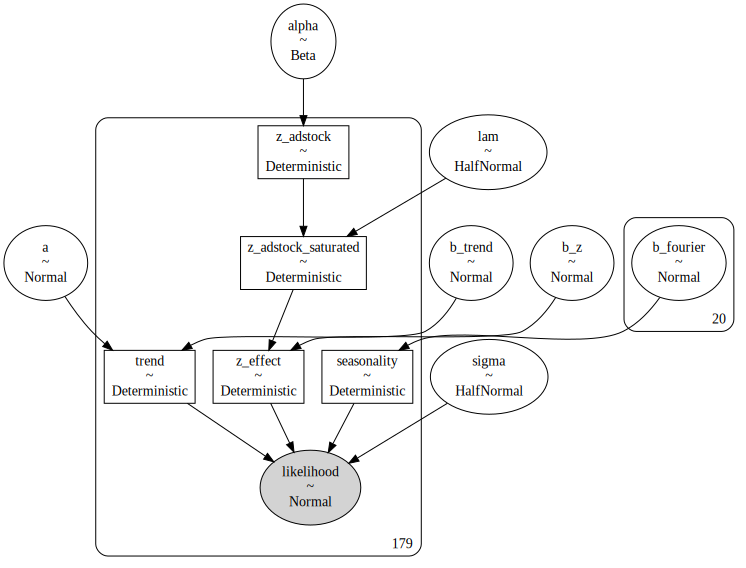

In [20]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as adstock_saturation_model:
    # --- priors ---
    ## intercept
    a = pm.Normal("a", mu=0, sigma=1)
    ## trend
    b_trend = pm.Normal("b_trend", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal("b_fourier", mu=0, sigma=2, dims="fourier_features")
    ## adstock effect
    alpha = pm.Beta("alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.HalfNormal("lam", sigma=5)
    ## regressor
    b_z = pm.Normal("b_z", mu=0, sigma=2)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal("sigma", sigma=0.1)

    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T)
    )
    z_adstock = pm.Deterministic("z_adstock", geometric_adstock(x=z, alpha=alpha, l=12))
    z_adstock_saturated = pm.Deterministic("z_adstock_saturated", logistic_saturation(x=z_adstock, lam=lam))
    z_effect = pm.Deterministic("z_effect", b_z * z_adstock_saturated)
    mu = trend  + seasonality  + z_effect
    
    # --- likelihood ---
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)

    # --- prior samples 
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(adstock_saturation_model)

- Prior Predictive Samples

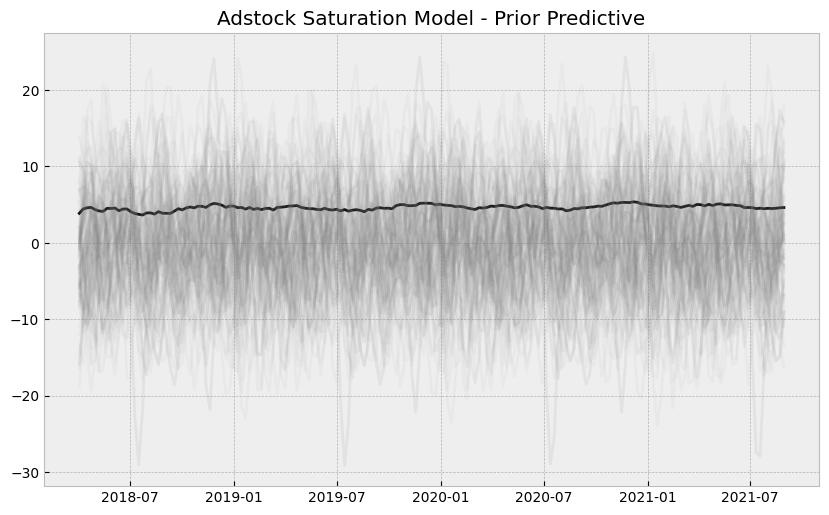

In [21]:
fig, ax = plt.subplots()
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.plot(
    date,
    _sample(array=adstock_saturation_model_prior_predictive["likelihood"], n_samples=100).T,
    color="gray",
    alpha=0.05,
)
ax.set(title="Adstock Saturation Model - Prior Predictive");

- Fit Model

In [22]:
with adstock_saturation_model:
    adstock_saturation_model_trace = pm.sample(
        tune=2000,
        draws=6000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )
    adstock_saturation_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=adstock_saturation_model_trace,
        samples=200
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_z, lam, alpha, b_fourier, b_trend, a]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 151 seconds.
The acceptance probability does not match the target. It is 0.88906218322305, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


- Model Diagnostics

In [23]:
az.summary(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_z", "alpha", "lam", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        4.025  0.036   3.956    4.091      0.000    0.000    7248.0   
b_trend  0.634  0.018   0.600    0.667      0.000    0.000   27773.0   
b_z      0.689  0.249   0.498    0.914      0.007    0.005    5699.0   
alpha    0.543  0.034   0.476    0.606      0.000    0.000   12087.0   
lam      0.128  0.033   0.062    0.187      0.000    0.000    5473.0   
sigma    0.067  0.004   0.060    0.074      0.000    0.000   19448.0   

         ess_tail  r_hat  
a          8013.0    1.0  
b_trend   18207.0    1.0  
b_z        2563.0    1.0  
alpha     14556.0    1.0  
lam        2549.0    1.0  
sigma     17956.0    1.0

Note that the values of $\alpha$ and $\lambda$ are very close to the true ones ($0.5$ and $0.15$ respectively). Moreover, the true values are included in the posterior distributions $94\%$ HDI.

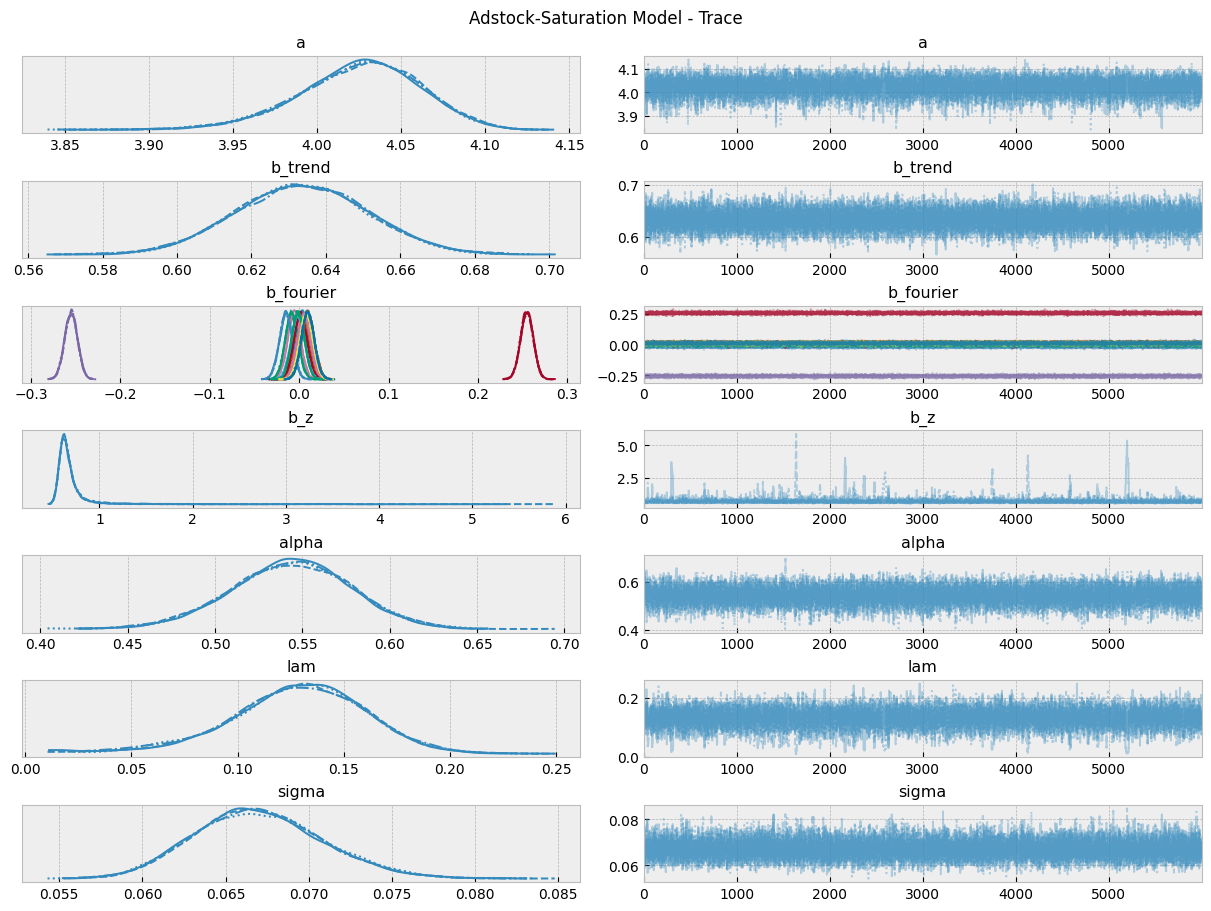

In [24]:
axes = az.plot_trace(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend", "b_fourier", "b_z", "alpha", "lam", "sigma"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation Model - Trace");

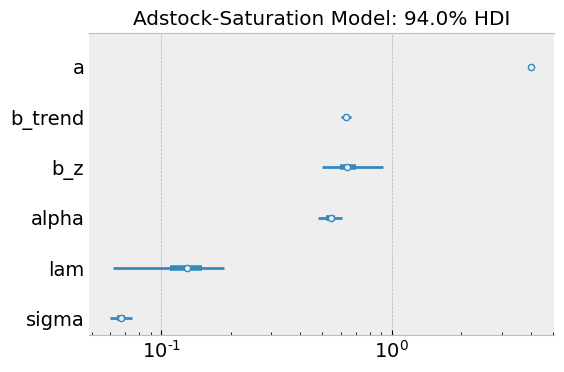

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=adstock_saturation_model_trace,
    var_names=["a", "b_trend",  "b_z", "alpha", "lam", "sigma"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation Model: 94.0% HDI",
    xscale="log"
);

- Posterior Predictive Samples

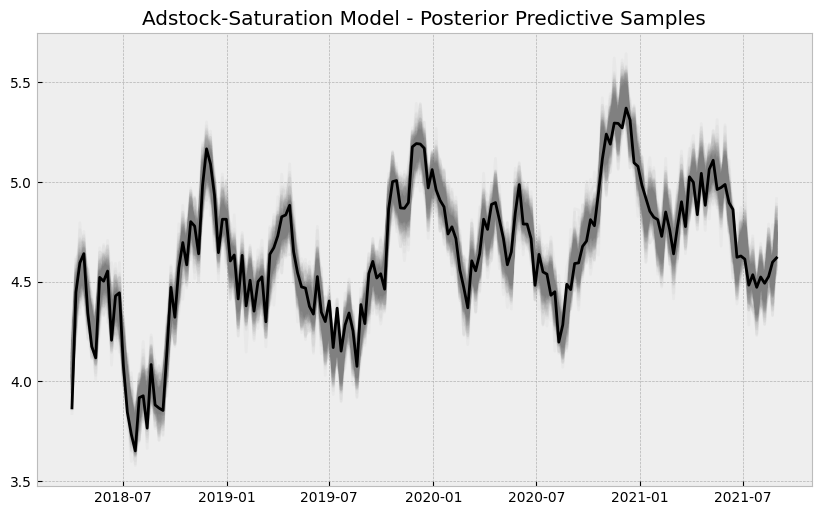

In [26]:
fig, ax = plt.subplots()
ax.plot(
    date,
    adstock_saturation_model_posterior_predictive["likelihood"].T,
    color="gray",
    alpha=0.05,
)
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.set(title="Adstock-Saturation Model - Posterior Predictive Samples");

- Estimated `z_effect`

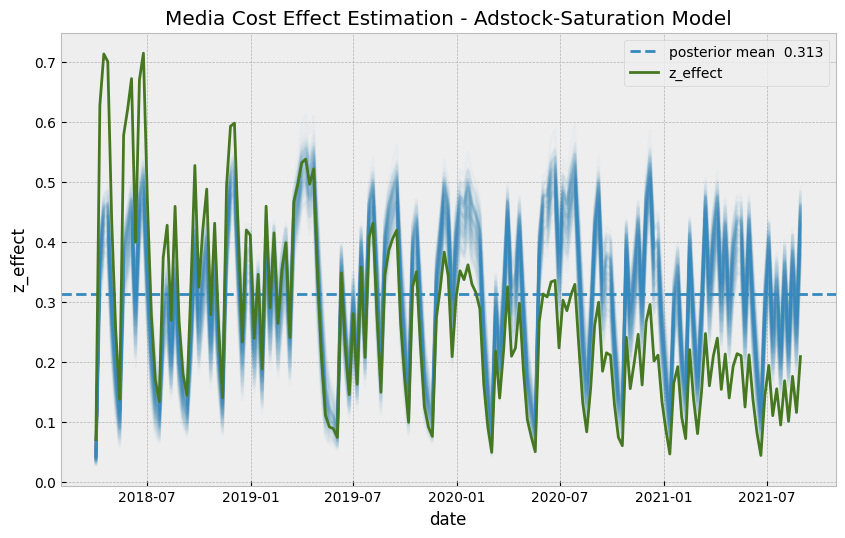

In [27]:
z_effect_posterior_samples = (
    adstock_saturation_model_trace["posterior"]["z_effect"].stack(sample=("chain", "draw"))
)

fig, ax = plt.subplots()
ax.plot(
    date,
    _sample(array=z_effect_posterior_samples.T, n_samples=100).T,
    color="C0",
    alpha=0.03,
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}"
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.set(title="Media Cost Effect Estimation - Adstock-Saturation Model");

This model captures more variance in the effect of `z` than the base model. This shows that the adstock and saturation transformations do make the difference. Note however that the diminishing returns effect is not present in this model, as the regression coefficient is not time-varying.

Finally, we look into the estimated against the true values for this adstock-saturation model. We would expect to find a non-linear patter because of the composition of these two transformations.

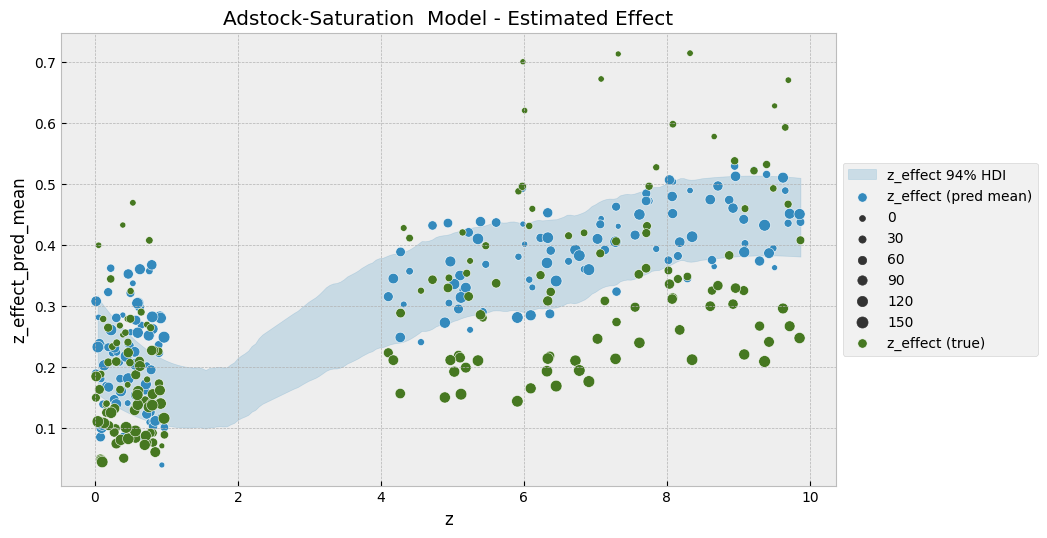

In [28]:
z_effect_pred_mean = adstock_saturation_model_trace["posterior"]["z_effect"] \
    .stack(sample=("chain", "draw")) \
    .mean(axis=1) \
    .to_numpy()

fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=adstock_saturation_model_trace["posterior"]["z_effect"],
    color="C0",
    fill_kwargs={
        "alpha": 0.2,
        "label": "z_effect 94% HDI"
    },
    ax=ax
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    label="z_effect (pred mean)",
    data=(
        data_df
        .assign(z_effect_pred_mean=z_effect_pred_mean)
    )
)
sns.scatterplot(
    x="z",
    y="z_effect",
    color="C3",
    size="index",
    label="z_effect (true)",
    data=data_df
)
h,l = ax.get_legend_handles_labels()
ax.legend(h[0:9], l[0:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation  Model - Estimated Effect");

As for the base-model, we encode the time component as the size of the points. Note that we indeed see a better fit and a non-linear pattern. For low values of `z` the effect seems constant whereas for larger values we see a non-linear pattern which saturates as expected.

### Adstock-Saturation-Diminishing-Returns (ASDR) Model

In this final model we add a time-varying coefficient for the adstock and saturation transformations (plus controlling for the trend and seasonality).

- Model Specification

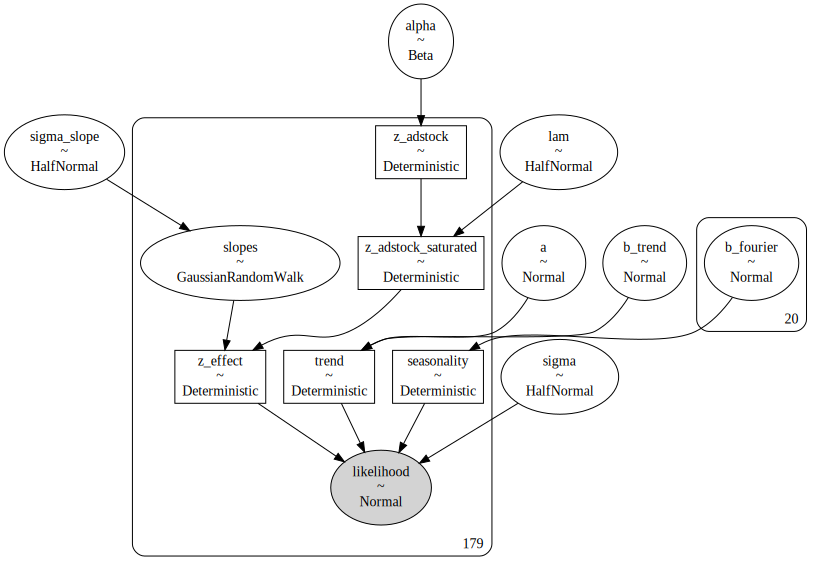

In [29]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as asdr_model:
    # --- priors ---
    ## intercept
    a = pm.Normal("a", mu=0, sigma=0.5)
    ## trend
    b_trend = pm.Normal("b_trend", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal("b_fourier", mu=0, sigma=2, dims="fourier_features")
    ## adstock effect
    alpha = pm.Beta("alpha", alpha=1, beta=1)
    ## saturation effect
    lam = pm.HalfNormal("lam", sigma=5)
    ## gaussian random walk standard deviation
    sigma_slope = pm.HalfNormal("sigma_slope", sigma=0.1)
    ## standard deviation of the normal likelihood
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    
    # --- model parametrization ---
    trend = pm.Deterministic("trend", a + b_trend * t)
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T)
    )
    slopes = pm.GaussianRandomWalk("slopes", sigma=sigma_slope, shape=date.size)
    z_adstock = pm.Deterministic("z_adstock", geometric_adstock(x=z, alpha=alpha, l=12))
    z_adstock_saturated = pm.Deterministic("z_adstock_saturated", logistic_saturation(x=z_adstock, lam=lam))
    z_effect = pm.Deterministic("z_effect", slopes * z_adstock_saturated)
    mu = trend  + seasonality  + z_effect
    
    # --- likelihood ---
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
    
    # --- prior samples ---
    asdr_model_prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(asdr_model)

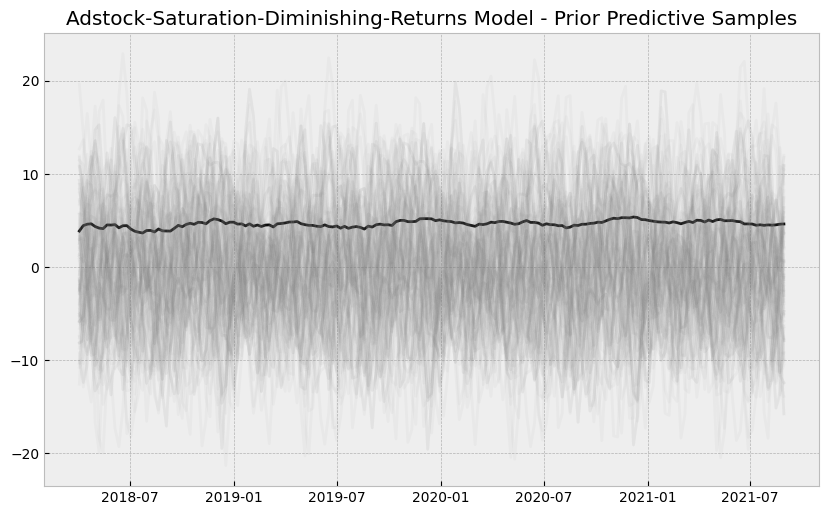

In [30]:
fig, ax = plt.subplots()
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.plot(
    date,
    _sample(array=asdr_model_prior_predictive["likelihood"], n_samples=100).T,
    color="gray",
    alpha=0.05,
)
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Prior Predictive Samples");

- Model Fit

In [31]:
with asdr_model:
    asdr_model_trace = pm.sample(
        tune=2000,
        draws=6000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )
    asdr_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=asdr_model_trace,
        samples=200,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slopes, sigma, sigma_slope, lam, alpha, b_fourier, b_trend, a]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 404 seconds.
The number of effective samples is smaller than 10% for some parameters.
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


- Model Diagnostics

In [32]:
az.summary(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "alpha", "lam", "sigma"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        3.852  0.036   3.785    3.920      0.000    0.000    8841.0   
b_trend  1.022  0.046   0.933    1.107      0.001    0.001    3763.0   
alpha    0.501  0.027   0.448    0.549      0.000    0.000    3753.0   
lam      0.169  0.025   0.122    0.216      0.001    0.000    1478.0   
sigma    0.048  0.003   0.043    0.054      0.000    0.000   18159.0   

         ess_tail  r_hat  
a         14426.0    1.0  
b_trend    6908.0    1.0  
alpha      7276.0    1.0  
lam        1685.0    1.0  
sigma     18347.0    1.0

As in the second model, the true values of $\alpha$ and $\lambda$ are included in the posterior distributions $94\%$ hdi.

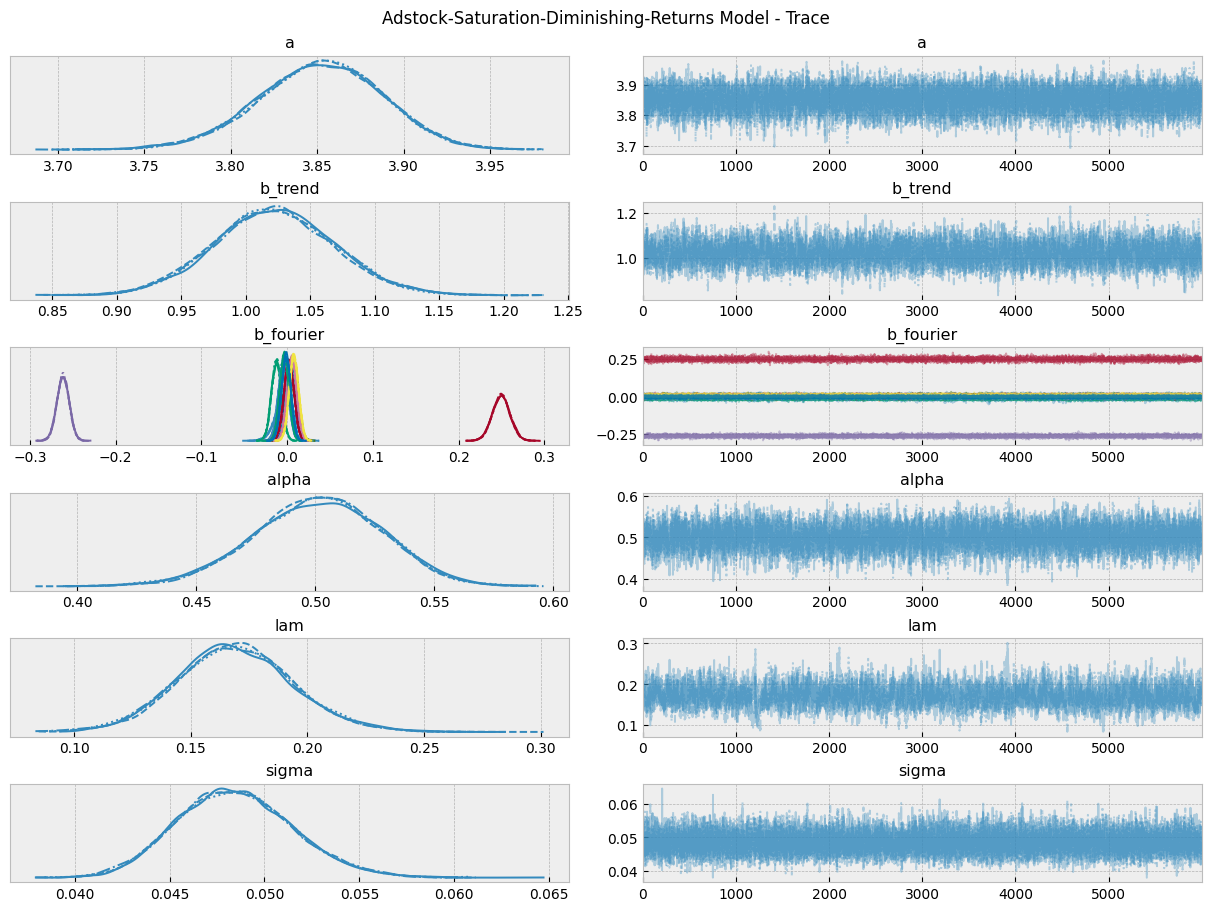

In [33]:
axes = az.plot_trace(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "b_fourier", "alpha", "lam", "sigma"],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation-Diminishing-Returns Model - Trace");

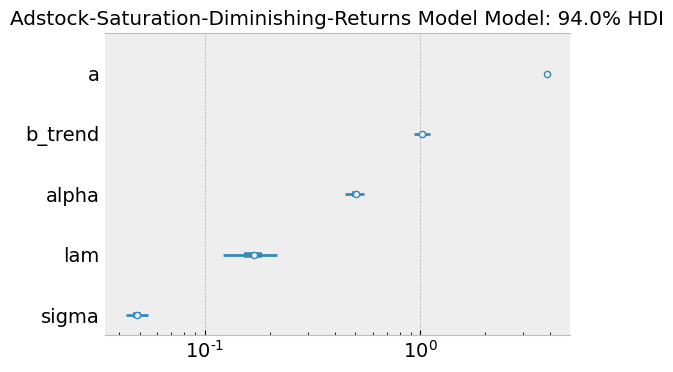

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_forest(
    data=asdr_model_trace,
    var_names=["a", "b_trend", "alpha", "lam", "sigma"],
    combined=True,
    ax=ax
)
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model Model: 94.0% HDI",
    xscale="log"
);

- Posterior Predictive Samples

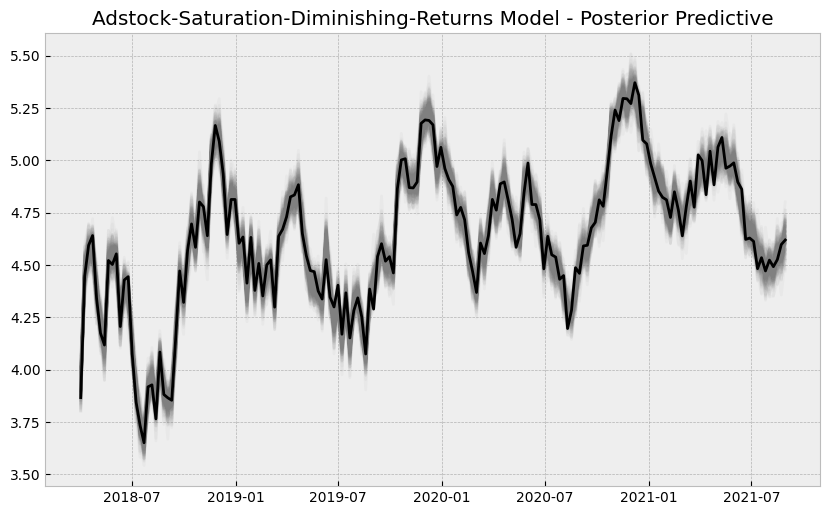

In [35]:
fig, ax = plt.subplots()
ax.plot(
    date,
    asdr_model_posterior_predictive["likelihood"].T,
    color="gray",
    alpha=0.05,
)
sns.lineplot(x=date, y=y, color="black", ax=ax)
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Posterior Predictive");

Now we want to deep dive into the parameters $\alpha$ and $\lambda$ of the adstock and saturation transformations respectively. First, let us look into their joint posterior distributions.

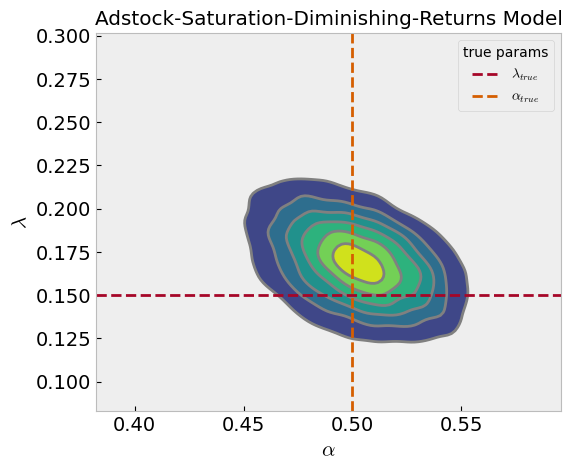

In [36]:
fig, ax = plt.subplots(figsize=(6, 5))
az.plot_pair(
    data=asdr_model_trace,
    var_names=["alpha", "lam"],
    kind="kde",
    divergences=True,
    ax=ax
)
ax.axhline(0.15, color="C1", linestyle="--", label="$\lambda_{true}$")
ax.axvline(0.5, color="C4", linestyle="--", label="$\\alpha_{true}$")
ax.legend(title="true params", loc="upper right")
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model",
    xlabel="$\\alpha$",
    ylabel="$\lambda$"
);

The true values are quite close to the posterior mode. Note that there seems to be a weak negative correlation between these two parameters.

In [37]:
corr, _ = pearsonr(
    x=asdr_model_trace.posterior["alpha"].stack(sample=("chain", "draw")).to_numpy(),
    y=asdr_model_trace.posterior["lam"].stack(sample=("chain", "draw")).to_numpy()
)

print(f"Correlation between alpha and lambda {corr: 0.3f}");

Correlation between alpha and lambda -0.416


- $\alpha$ deep dive

Now, we can look into the posterior distribution of the of `z` when applying the `geometric_adstock` transformation for all the $\alpha$ posterior samples.

In [38]:
alpha_posterior = asdr_model_trace["posterior"]["alpha"].stack(sample=("chain", "draw"))

alpha_posterior_samples = _sample(array=alpha_posterior.T, n_samples=100)

# pass z through the adstock transformation
geometric_adstock_posterior_samples = np.array([
    geometric_adstock(x=z, alpha=x).eval()
    for x in alpha_posterior_samples
])

Let us compare the estimates against the true values.

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_5346/797217844.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)


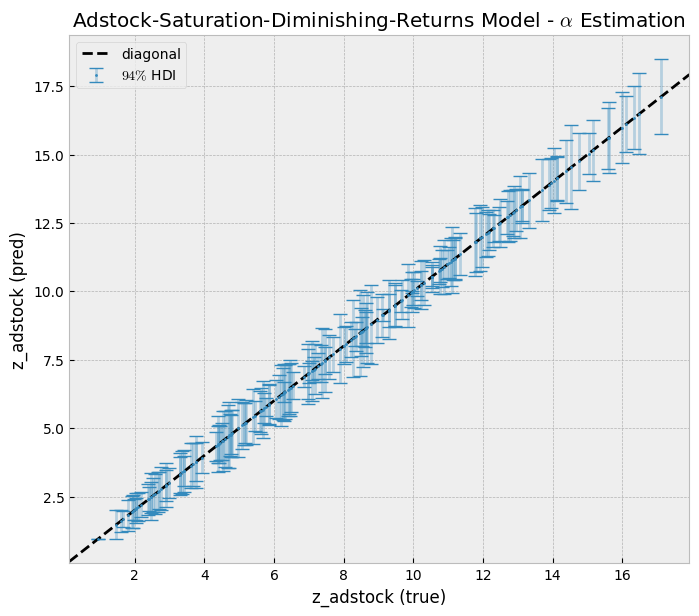

In [39]:
geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)

yerr = geometric_adstock_hdi[:, 1] - geometric_adstock_hdi[:, 0]

fig, ax = plt.subplots(figsize=(8, 7))

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=geometric_adstock_posterior_samples.mean(axis=0), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=1,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
ax.axline(
    xy1=(10, 10),
    slope=1.0,
    color="black",
    linestyle="--",
    label="diagonal"
)
ax.legend()
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\\alpha$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock (pred)",
);

We see that the model is capturing the adstock transformation (within the model uncertainty limits). Note how the hdi intervals increase as a function of `z_adstock` (true).

- $\lambda$ deep dive

Next we look into the $\lambda$ parameter. We follow the a similar strategy as above.

In [40]:
lam_posterior = asdr_model_trace["posterior"]["lam"].stack(sample=("chain", "draw"))

lam_posterior_samples = _sample(array=lam_posterior.T, n_samples=100)

logistic_saturation_posterior_samples = np.array([
    logistic_saturation(x=x, lam=lam_posterior_samples).eval()
    for x in data_df["z_adstock"].values
])

We can now plot the estimated saturation curve against the true one.

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_5346/1422980558.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)


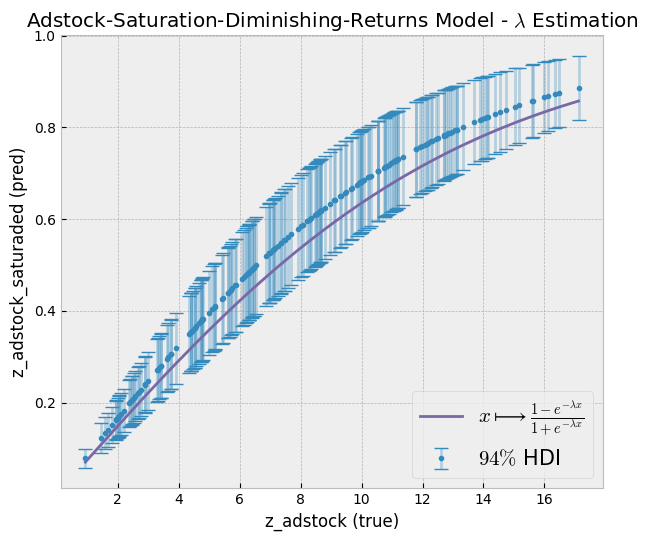

In [41]:
logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)

yerr = logistic_saturation_hdi[:, 1] - logistic_saturation_hdi[:, 0]


fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}$"

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=logistic_saturation_posterior_samples.mean(axis=1), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=3,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 15})
ax.set(
    title="Adstock-Saturation-Diminishing-Returns Model - $\lambda$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock_saturaded (pred)",
);

The true saturation curve lies within the $94\%$ hdi estimated by the model.

- Estimated `z_effect`

Let us look into the estimated effect of `z` on `y` inferred by the model against the true one from the data generation process.

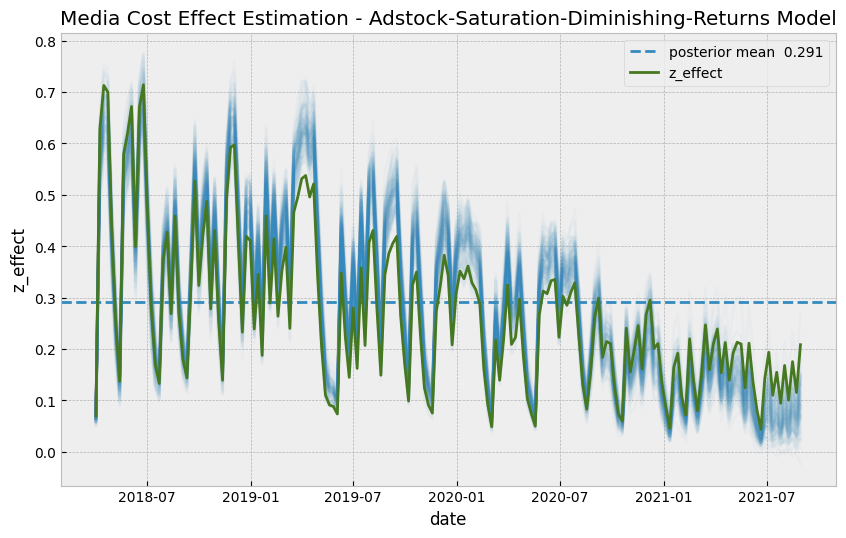

In [42]:
z_effect_posterior_samples = (
    asdr_model_trace["posterior"]["z_effect"].stack(sample=("chain", "draw"))
)

fig, ax = plt.subplots()
ax.plot(
    date,
    _sample(array=z_effect_posterior_samples.T, n_samples=100).T,
    color="C0",
    alpha=0.03,
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}"
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.set(title="Media Cost Effect Estimation - Adstock-Saturation-Diminishing-Returns Model");

As expected, we get a very good fit. In particular, the model is capturing the time-varying effect as a result of the gaussian random walk component. As above, we can now look into the estimated vs true scatter plot.

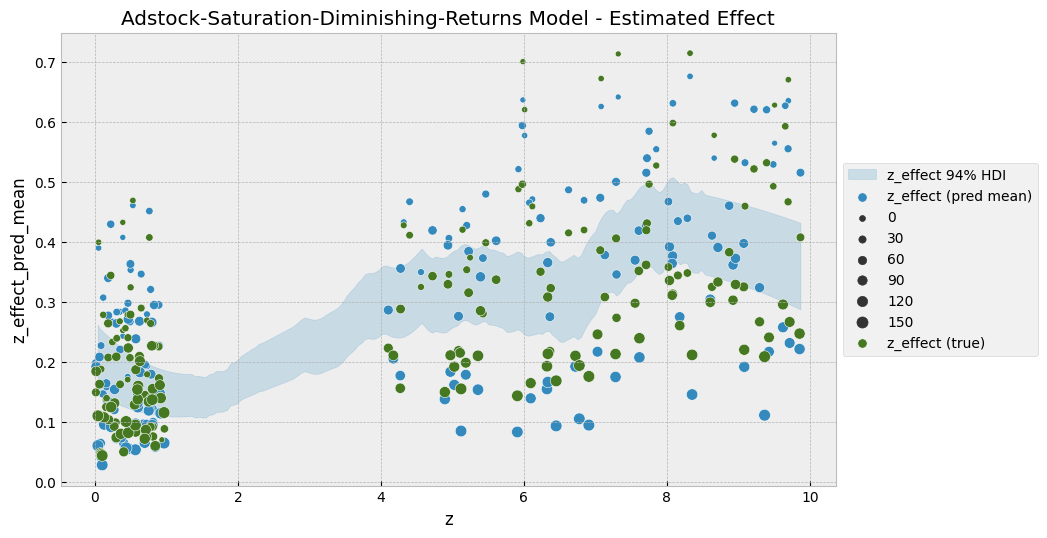

In [43]:
z_effect_pred_mean = asdr_model_trace["posterior"]["z_effect"] \
    .stack(sample=("chain", "draw")) \
    .mean(axis=1) \
    .to_numpy()

fig, ax = plt.subplots()

az.plot_hdi(
    x=z,
    y=asdr_model_trace["posterior"]["z_effect"],
    color="C0",
    fill_kwargs={
        "alpha": 0.2,
        "label": "z_effect 94% HDI"
    },
    ax=ax
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    label="z_effect (pred mean)",
    data=(
        data_df
        .assign(z_effect_pred_mean=z_effect_pred_mean)
    )
)
sns.scatterplot(
    x="z",
    y="z_effect",
    color="C3",
    size="index",
    label="z_effect (true)",
    data=data_df
)
h,l = ax.get_legend_handles_labels()
ax.legend(h[0:9], l[0:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Adstock-Saturation-Diminishing-Returns Model - Estimated Effect");

It is interesting to see that the non-linear pattern does not look precisely as a logistic saturation. One of the main reasons for this is the diminishing returns in the time component. We can better see the logistic-like saturation if we factor the time component, for example by splitting by year:

In [44]:
z_effect_hdi = az.hdi(asdr_model_trace["posterior"])["z_effect"].to_numpy()

data_df = data_df.assign(
    z_effect_pred_mean=z_effect_pred_mean,
    z_effect_hdi_lower=z_effect_hdi[:, 0],
    z_effect_hdi_upper=z_effect_hdi[:, 1]
)

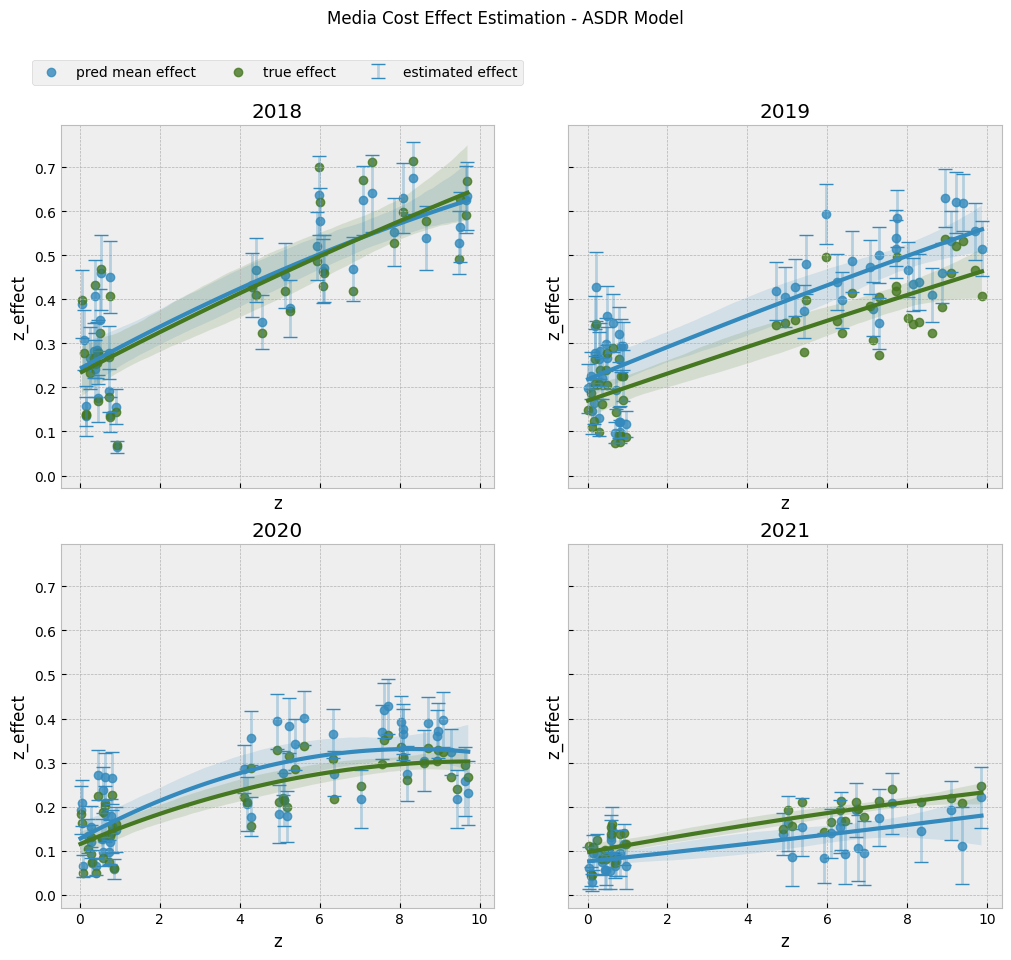

In [45]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 9), 
    sharex=True,
    sharey=True,
    layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    ax = axes[i]
    mask = f"year == {year}"
    
    yerr = data_df.query(mask)["z_effect_hdi_upper"] - data_df.query(mask)["z_effect_hdi_lower"]
    
    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["z"], 
        y=data_df.query(mask)["z_effect_pred_mean"], 
        yerr=yerr/2,
        color="C0",
        fmt='o',
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]
    sns.regplot(
        x="z", 
        y="z_effect_pred_mean",
        order=2,
        color="C0",
        label="pred mean effect",
        data=data_df.query(mask),
        ax=ax,
    )
    sns.regplot(
        x="z", 
        y="z_effect",
        order=2,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        ax=ax,
    )
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")
    
fig.suptitle("Media Cost Effect Estimation - ASDR Model", y=1.05);

The results look very good! These are exactly the curves we would need for decision making and budget allocation.

**Remark:** Note that this plot looks very similar to the one obtained in the post [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/). The main difference is that in the previous post we could only estimated the effect of `z_adstock` on `y` while in this one we estimate the effect of `z` on `y` directly by learning the adstock effect from the data.

## Model Comparison

To end this notebook, let us compare the three models.

In [46]:
dataset_dict = {
    "base_model": base_model_trace,
    "adstock_saturation_model": adstock_saturation_model_trace,
    "asdr_model": asdr_model_trace,
}

az.compare(dataset_dict=dataset_dict, ic="loo", method="stacking", scale="log")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/arviz/stats/stats.py:248: FutureWarning: The

rank         loo      p_loo       d_loo    weight  \
asdr_model                   0  264.522177  38.899674    0.000000  0.966124   
adstock_saturation_model     1  215.808703  25.182431   48.713474  0.033876   
base_model                   2  160.286717  23.220650  104.235460  0.000000   

                                 se        dse  warning loo_scale  
asdr_model                 9.357121   0.000000    False       log  
adstock_saturation_model   8.976849   9.725725     True       log  
base_model                11.823211  13.979901    False       log

We clearly see that the `asdr_model` is the best one (no surprise here). However, this evaluation methods throws some warning which we would need to investigate further.